## Multi-Class Logistic Regression Model for Cell Annotation
#### Using data from a multiple sclerosis dataset as an example

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import scanpy as sc
import time

In [2]:
# Import data
adata_train = sc.read('/home/amomtaz/Beng199_Projects/scGPT/msStudyData/filtered_ms_adata.h5ad')
adata_test = sc.read('/home/amomtaz/Beng199_Projects/scGPT/msStudyData/c_adata.h5ad')
train_celltype_column = "Factor Value[inferred cell type - authors labels]"
test_celltype_column = "Factor Value[inferred cell type - authors labels]"
print(adata_test.X.shape,adata_train.X.shape)

(7844, 3000) (13468, 3000)


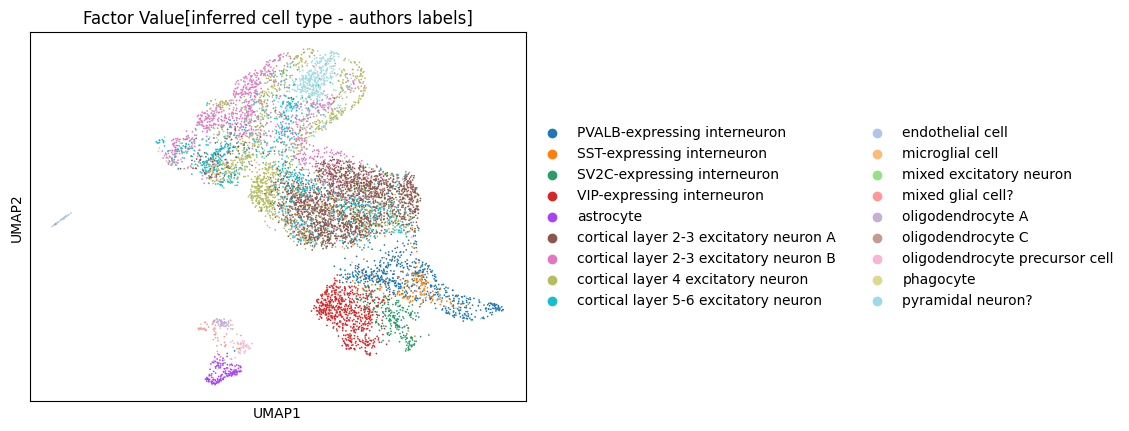

In [3]:
sc.pl.umap(adata_test,color=test_celltype_column,size=6)

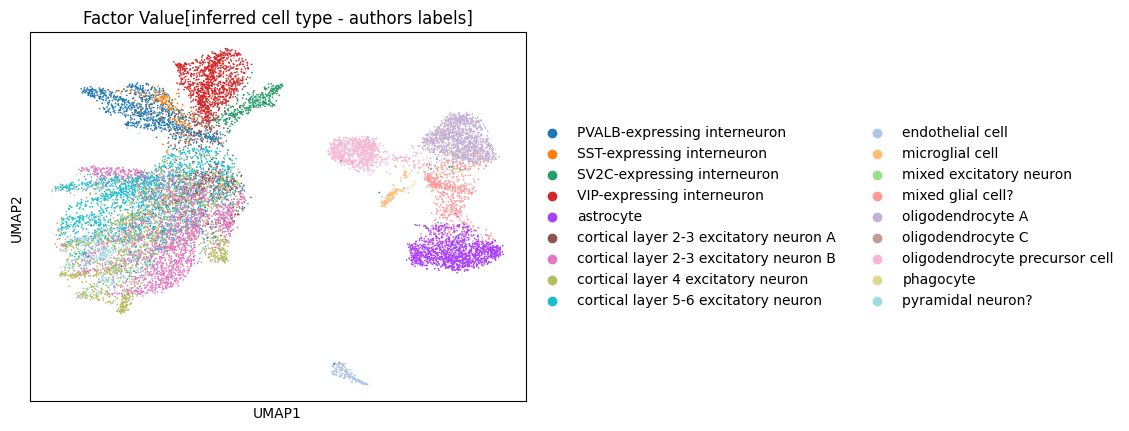

In [4]:
sc.pl.umap(adata_train,color=train_celltype_column,size=6)

In [5]:
# Device configs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 10
learning_rate = 0.001
input_size = len(adata_train.var_names)
hidden_size1 = 1500
hidden_size2 = 750
output_size = len(adata_train.obs[train_celltype_column].unique())
batch_size = 200

In [6]:
# Transform
class adataDataset(Dataset):
    def __init__(self,data,encoded_labels):
        super(adataDataset,self).__init__()
        data = data.X.toarray()
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(encoded_labels, dtype=torch.long)
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

label_encoder = LabelEncoder()
adata_train.obs['label_encoded'] = label_encoder.fit_transform(adata_train.obs[train_celltype_column])
adata_test.obs['label_encoded'] = label_encoder.transform(adata_test.obs[test_celltype_column])

train_data = adataDataset(adata_train,adata_train.obs['label_encoded'].values)
test_data = adataDataset(adata_test,adata_test.obs['label_encoded'].values)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [7]:
# Define model
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size1,hidden_size2,output_size):
        super(NeuralNet,self).__init__()
        self.linear1 = nn.Linear(input_size,hidden_size1)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size1,hidden_size2)
        self.linear3 = nn.Linear(hidden_size2,output_size)

    def forward(self,x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        return out

# Send model to specified number of GPUs
model = NeuralNet(input_size,hidden_size1,hidden_size2,output_size)
if torch.cuda.device_count() > 1:
    device_indices = [0,1,2] # Change this based on how many GPUs you have
    model = nn.DataParallel(model, device_ids=device_indices)
model.to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [8]:
# Training loop
steps_in_epoch = len(train_loader)
since = time.time()
for epoch in range(num_epochs):
    for i, (counts, labels) in enumerate(train_loader):
        counts = counts.to(device)
        labels = labels.to(device)

        # forward
        outputs = model(counts)
        loss = criterion(outputs, labels)

        # backwards
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1)%20 == 0:
            time_elapsed = time.time()-since
            print(f'Epoch: {epoch+1} Step: {i+1}/{steps_in_epoch} Loss: {loss.item():.3f} Time: {time_elapsed//60}m {time_elapsed%60:.1f}s')

Epoch: 1 Step: 20/68 Loss: 0.691 Time: 0.0m 1.0s
Epoch: 1 Step: 40/68 Loss: 0.556 Time: 0.0m 1.1s
Epoch: 1 Step: 60/68 Loss: 0.293 Time: 0.0m 1.1s
Epoch: 2 Step: 20/68 Loss: 0.252 Time: 0.0m 1.3s
Epoch: 2 Step: 40/68 Loss: 0.220 Time: 0.0m 1.3s
Epoch: 2 Step: 60/68 Loss: 0.213 Time: 0.0m 1.4s
Epoch: 3 Step: 20/68 Loss: 0.104 Time: 0.0m 1.5s
Epoch: 3 Step: 40/68 Loss: 0.090 Time: 0.0m 1.6s
Epoch: 3 Step: 60/68 Loss: 0.068 Time: 0.0m 1.7s
Epoch: 4 Step: 20/68 Loss: 0.013 Time: 0.0m 1.8s
Epoch: 4 Step: 40/68 Loss: 0.022 Time: 0.0m 1.9s
Epoch: 4 Step: 60/68 Loss: 0.019 Time: 0.0m 2.0s
Epoch: 5 Step: 20/68 Loss: 0.018 Time: 0.0m 2.1s
Epoch: 5 Step: 40/68 Loss: 0.005 Time: 0.0m 2.2s
Epoch: 5 Step: 60/68 Loss: 0.020 Time: 0.0m 2.3s
Epoch: 6 Step: 20/68 Loss: 0.004 Time: 0.0m 2.4s
Epoch: 6 Step: 40/68 Loss: 0.002 Time: 0.0m 2.5s
Epoch: 6 Step: 60/68 Loss: 0.005 Time: 0.0m 2.6s
Epoch: 7 Step: 20/68 Loss: 0.002 Time: 0.0m 2.7s
Epoch: 7 Step: 40/68 Loss: 0.003 Time: 0.0m 2.8s
Epoch: 7 Step: 60/68

In [9]:
# Test
with torch.no_grad():
    num_correct = 0
    num_samples = 0
    n_class_correct = [0 for i in range(output_size)]
    n_class_samples = [0 for i in range(output_size)]
    predArray = []
    for counts, labels in test_loader:
        counts = counts.to(device)
        labels = labels.to(device)
        outputs = model(counts)

        _, predictions = torch.max(outputs,1)
        predArray += predictions.tolist()
        num_correct += (predictions == labels).sum().item()
        num_samples += labels.shape[0]

        for i in range(len(labels)):
            label = labels[i]
            pred = predictions[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    adata_test.obs['Predictions'] = label_encoder.inverse_transform(predArray)

    print(f'Acc: {num_correct/num_samples}')

    for i in range(output_size):
        acc = n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {label_encoder.inverse_transform([i])[0]}: {acc:.2f}')

Acc: 0.7797042325344212
Accuracy of PVALB-expressing interneuron: 0.96
Accuracy of SST-expressing interneuron: 0.72
Accuracy of SV2C-expressing interneuron: 0.87
Accuracy of VIP-expressing interneuron: 0.98
Accuracy of astrocyte: 0.99
Accuracy of cortical layer 2-3 excitatory neuron A: 0.53
Accuracy of cortical layer 2-3 excitatory neuron B: 0.89
Accuracy of cortical layer 4 excitatory neuron: 0.80
Accuracy of cortical layer 5-6 excitatory neuron: 0.89
Accuracy of endothelial cell: 1.00
Accuracy of microglial cell: 0.75
Accuracy of mixed excitatory neuron: 0.07
Accuracy of mixed glial cell?: 0.85
Accuracy of oligodendrocyte A: 0.98
Accuracy of oligodendrocyte C: 0.33
Accuracy of oligodendrocyte precursor cell: 0.89
Accuracy of phagocyte: 0.67
Accuracy of pyramidal neuron?: 0.83


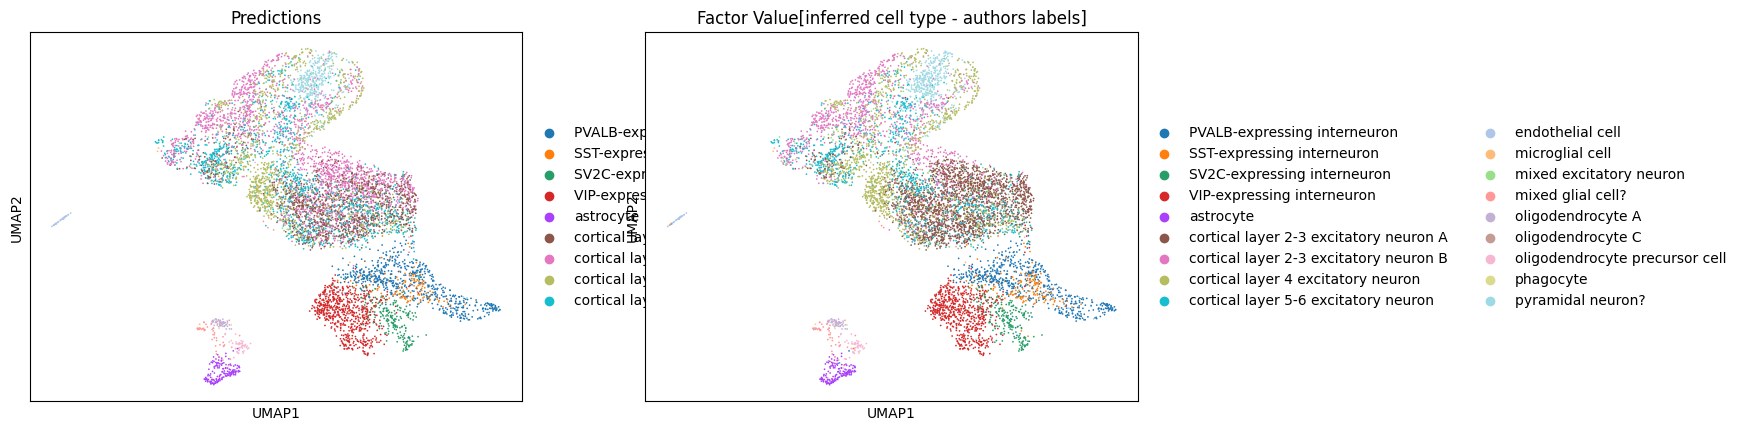

In [10]:
sc.pl.umap(adata_test,color=['Predictions',test_celltype_column],size=6)